# Support Vector Data Description

In [1]:
import cvxopt as cvx
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dt

### Parameters

In [2]:
np.random.seed(421)
class_means = np.array([[+4.0, +4.0],
                        [-1.5, +0.5],
                        [+1.5, -1.5]])
class_covariances = np.array([[[+0.1, 0.0],
                               [0.0, +0.1]],
                              [[+0.2, 0.0],
                               [0.0, +0.2]],
                              [[+0.2, 0.0],
                               [0.0, +0.2]]])
class_sizes = np.array([2, 149, 149])

### Data Generation

In [4]:
points1 = np.random.multivariate_normal(class_means[0,:], class_covariances[0,:,:], class_sizes[0])
points2 = np.random.multivariate_normal(class_means[1,:], class_covariances[1,:,:], class_sizes[1])
points3 = np.random.multivariate_normal(class_means[2,:], class_covariances[2,:,:], class_sizes[2])
X = np.vstack((points1, points2, points3))

### Exporting Data

In [6]:
np.savetxt("data_set_data_description.csv", X, fmt = "%f,%f")

### Plotting Data

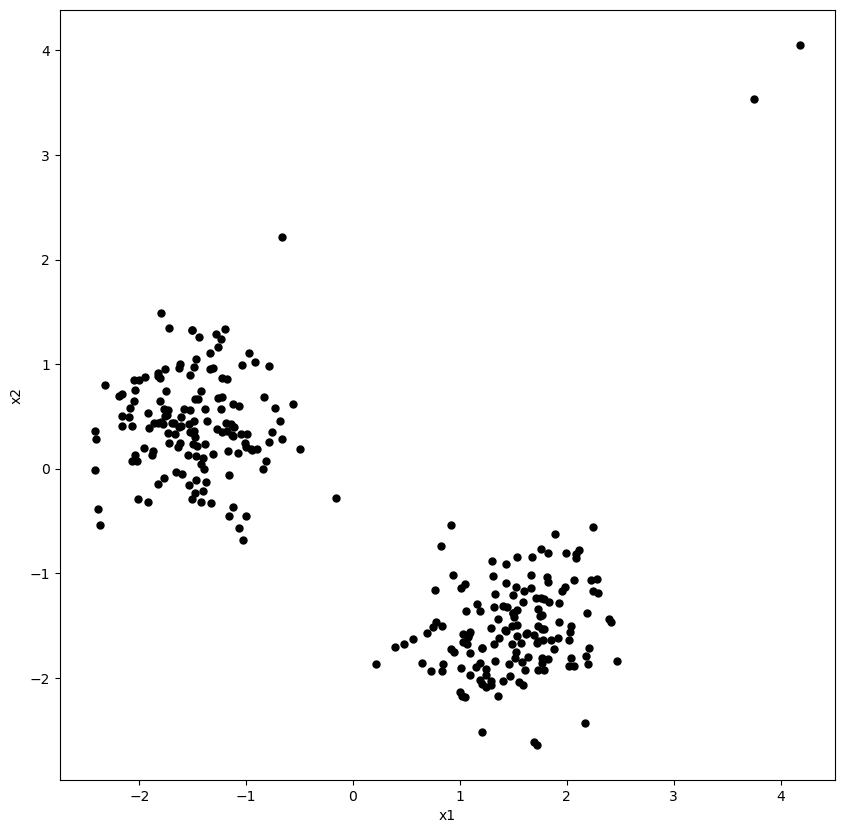

In [7]:
plt.figure(figsize = (10, 10))
plt.plot(X[:,0], X[:,1], "k.", markersize = 10)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

### Importing Data

In [8]:
data_set = np.genfromtxt("data_set_data_description.csv", delimiter = ",")
X_train = data_set[:,[0, 1]]
N_train = X_train.shape[0]
D_train = X_train.shape[1]

### Distance and Kernel Functions

$\begin{equation}
    \begin{split}
        d(\boldsymbol{x}_{i}, \boldsymbol{x}_{j}) &= ||\boldsymbol{x}_{i} - \boldsymbol{x}_{j}||_{2} = \sqrt{(\boldsymbol{x}_{i} - \boldsymbol{x}_{j})^{\top} (\boldsymbol{x}_{i} - \boldsymbol{x}_{j})} = \sqrt{\sum\limits_{d = 1}^{D}(x_{id} - x_{jd})^{2}} \\
        k(\boldsymbol{x}_{i}, \boldsymbol{x}_{j}) &= \exp\left(-\dfrac{||\boldsymbol{x}_{i} -\boldsymbol{x}_{j}||_{2}^{2}}{2s^{2}}\right)
    \end{split}
\end{equation}$

In [9]:
def linear_kernel(X1, X2):
    K = X1 @ X2.T
    return(K)

def gaussian_kernel(X1, X2, s):
    D = dt.cdist(X1, X2)
    K = np.exp(-D**2 / (2 * s**2))
    return(K)

### Learning Algorithm

#### Primal Problem
$\begin{equation}
	\begin{split}
		\mbox{minimize}\;\;& R^{2} + C \sum\limits_{i = 1}^{N} \xi_{i} \\
		\mbox{with respect to}\;\;& \boldsymbol{a} \in \mathbb{R}^{D},\;\; \boldsymbol{\xi} \in \mathbb{R}^{N},\;\; R \in \mathbb{R} \\
		\mbox{subject to}\;\;& \|\boldsymbol{x}_{i} - \boldsymbol{a}\|_{2}^{2}  \leq R^{2} + \xi_{i} \;\;\;\; i = 1,2,\dots,N \\
		& \xi_{i} \geq 0\;\;\;\; i = 1,2,\dots,N \\
		\mbox{where}\;\;& C \in \mathbb{R}_{+}
	\end{split}
\end{equation}$

#### Dual Problem
$\begin{equation}
	\begin{split}
		\mbox{maximize}\;\;& \sum\limits_{i = 1}^{N} \alpha_{i} k(\boldsymbol{x}_{i}, \boldsymbol{x}_{i}) - \sum\limits_{i = 1}^{N} \sum\limits_{j = 1}^{N} \alpha_{i} \alpha_{j}  k(\boldsymbol{x}_{i}, \boldsymbol{x}_{j}) \\
		\mbox{with respect to}\;\;& \boldsymbol{\alpha} \in \mathbb{R}^{N} \\
		\mbox{subject to}\;\;& \sum\limits_{i = 1}^{N} \alpha_{i} = 1 \\
		& 0 \leq \alpha_{i} \leq C\;\;\;\; i = 1,2,\dots,N \\
		\mbox{where}\;\;& C \in \mathbb{R}_{+}
	\end{split}
\end{equation}$

#### Dual Problem in Matrix-Vector Form
$\begin{equation}
	\begin{split}
		\mbox{minimize}\;\;&-\dfrac{1}{2}\mbox{diag}(\mathbf{K})^{\top} \boldsymbol{\alpha} + \dfrac{1}{2} \boldsymbol{\alpha}^{\top} \mathbf{K} \boldsymbol{\alpha} \\
		\mbox{with respect to}\;\; & \boldsymbol{\alpha} \in \mathbb{R}^{N} \\
		\mbox{subject to}\;\;& \boldsymbol{1}^{\top} \boldsymbol{\alpha} = 1 \\
		& \boldsymbol{0} \leq \boldsymbol{\alpha} \leq C \boldsymbol{1} \\
		\mbox{where}\;\;& C \in \mathbb{R}_{+}
	\end{split}
\end{equation}$

In [10]:
s = 2
K_train = gaussian_kernel(X_train, X_train, s)
C = 0.15
epsilon = 1e-3

P = cvx.matrix(K_train)
q = cvx.matrix(-0.5 * np.diag(K_train))
G = cvx.matrix(np.vstack((-np.eye(N_train), np.eye(N_train))))
h = cvx.matrix(np.vstack((np.zeros((N_train, 1)), C * np.ones((N_train, 1)))))
A = cvx.matrix(np.ones((1, N_train)))
b = cvx.matrix(1.0)

result = cvx.solvers.qp(P, q, G, h, A, b)
alpha = np.reshape(result["x"], N_train)
alpha[alpha < C * epsilon] = 0
alpha[alpha > C * (1 - epsilon)] = C
    
support_indices, = np.where(alpha != 0)
active_indices, = np.where(np.logical_and(alpha != 0, alpha < C))
R = np.sqrt(np.matmul(alpha[support_indices], np.matmul(K_train[np.ix_(support_indices, support_indices)], alpha[support_indices])) + np.mean(np.diag(K_train[np.ix_(active_indices, active_indices)])) - 2 * np.mean(np.matmul(K_train[np.ix_(active_indices, support_indices)], alpha[support_indices])))

     pcost       dcost       gap    pres   dres
 0: -3.3574e-01 -4.5747e+01  7e+02  9e+00  5e-16
 1: -2.9285e-01 -3.5274e+01  4e+01  1e-01  5e-16
 2: -2.6161e-01 -2.9975e+00  3e+00  6e-03  6e-16
 3: -2.8968e-01 -1.2088e+00  9e-01  2e-03  5e-16
 4: -3.1882e-01 -5.4989e-01  2e-01  9e-05  2e-16
 5: -3.3150e-01 -4.8049e-01  1e-01  2e-05  2e-16
 6: -3.4081e-01 -3.9589e-01  6e-02  4e-06  1e-16
 7: -3.4775e-01 -3.7334e-01  3e-02  9e-07  1e-16
 8: -3.5065e-01 -3.6648e-01  2e-02  4e-08  1e-16
 9: -3.5328e-01 -3.5954e-01  6e-03  2e-09  1e-16
10: -3.5435e-01 -3.5731e-01  3e-03  4e-10  1e-16
11: -3.5514e-01 -3.5608e-01  9e-04  9e-11  1e-16
12: -3.5541e-01 -3.5569e-01  3e-04  3e-16  1e-16
13: -3.5554e-01 -3.5554e-01  8e-06  1e-15  1e-16
14: -3.5554e-01 -3.5554e-01  1e-07  1e-15  1e-16
Optimal solution found.


### Visualization

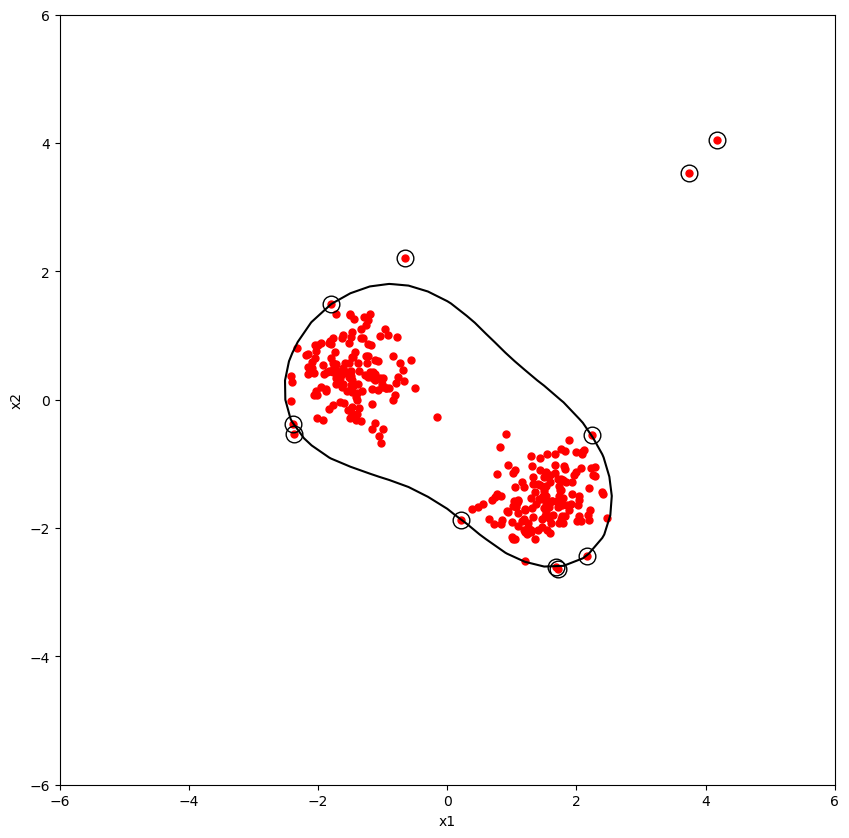

In [11]:
x1_interval = np.linspace(-6, +6, 41)
x2_interval = np.linspace(-6, +6, 41)
x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)
X_test = np.transpose(np.vstack((x1_grid.flatten(), x2_grid.flatten())))
K_test_train = gaussian_kernel(X_test, X_train, s)
K_test_test = gaussian_kernel(X_test, X_test, s)
discriminant_values = np.reshape(R**2 - np.matmul(alpha[support_indices], np.matmul(K_train[np.ix_(support_indices, support_indices)], alpha[support_indices])) + 2 * np.matmul(K_test_train, alpha) - np.diag(K_test_test), x1_grid.shape)

plt.figure(figsize = (10, 10))
plt.plot(X_train[:,0], X_train[:,1], "r.", markersize = 10)
plt.plot(X_train[support_indices, 0], X_train[support_indices, 1],
         "ko", markersize = 12, fillstyle = "none")
plt.contour(x1_grid, x2_grid, discriminant_values,
            levels = 0, colors = "k", linestyles = ["dashed", "solid", "dashed"])
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()